In [1]:
from os import walk
from os.path import join
import pandas as pd
import time
import numpy as np


import matplotlib.pyplot as plt

%matplotlib inline

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup

from wordcloud import WordCloud

from PIL import Image

In C:\Users\Nagaraj U\Downloads\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Nagaraj U\Downloads\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Nagaraj U\Downloads\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Nagaraj U\Downloads\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Nagaraj U\Downloads\anaconda

In [2]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

EMAIL_TEXT_JSON_PATH = 'SpamData/01_Processing/email-text.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'


SPAM_CAT = 1
NONSPAM_CAT = 0
VOCABULARY_SIZE = 2500

TRAINING_DATA = 'SpamData/02_Training/train-data.txt'
TESTING_DATA = 'SpamData/02_Training/test-data.txt'

WHALE_FILE =  'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'

THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
def get_email_body(path):
    
    for root, dirname, filenames in walk(path):
        for file_name in filenames:
            filepath = join(root,file_name)

            stream = open(filepath, encoding='latin_1')
            is_body = False
            lines = []
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body=True

            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body


In [6]:
def dataframe_from_directory(path,classification):
    rows = []
    rows_name = []
    for file_name, email_body in get_email_body(path):
        rows.append({'MESSAGE' : email_body, 'CATEGORY' : classification})
        rows_name.append(file_name)
        
    return pd.DataFrame(rows,index=rows_name)
        
    

In [7]:
spam_emails =  dataframe_from_directory(SPAM_1_PATH,SPAM_CAT) # 1 : spam 0 : nonspam
spam_emails = spam_emails.append( dataframe_from_directory(SPAM_2_PATH,SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [8]:
spam_emails.shape

(1898, 2)

In [9]:
non_spam_emails = dataframe_from_directory(NONSPAM_1_PATH,NONSPAM_CAT)
non_spam_emails = non_spam_emails.append(dataframe_from_directory(NONSPAM_2_PATH,NONSPAM_CAT))
print(non_spam_emails.shape)
non_spam_emails.head()

(3901, 2)


,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [10]:
data = pd.concat([spam_emails,non_spam_emails])
print(f' shape of entire dataframe is {data.shape}')

 shape of entire dataframe is (5799, 2)


In [11]:
data.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


## Checking for null or missing values

In [12]:
data['MESSAGE'].isnull().values.any()

False

In [13]:
#Removing system file entries (cmds files)
data = data.drop(['cmds'])

In [14]:
data.shape 

(5796, 2)

## Assigning document ID to each row 

In [15]:
document_ids = range(0,len(data.index))
data['DOC_ID'] = document_ids  # column to hold index 0-5796

In [16]:
data['FILE_NAME'] = data.index   #creating separate column to hold original file names
data.set_index('DOC_ID',inplace=True)  #changing index from filenales to DOC_ID
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


## storing emails data to json file

In [18]:
data.to_json(EMAIL_TEXT_JSON_PATH)

## calculating amount of spam and legit emails

In [19]:
data['CATEGORY'].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [20]:
amount_of_spam = data['CATEGORY'].value_counts()[1]
amount_of_ham = data['CATEGORY'].value_counts()[0]

category_names = ['spam' , 'legit emails']
sizes = [amount_of_spam ,amount_of_ham]

chart_colors = ['#b2ebf2','#e97171']

## Visualizing spam and legit emails

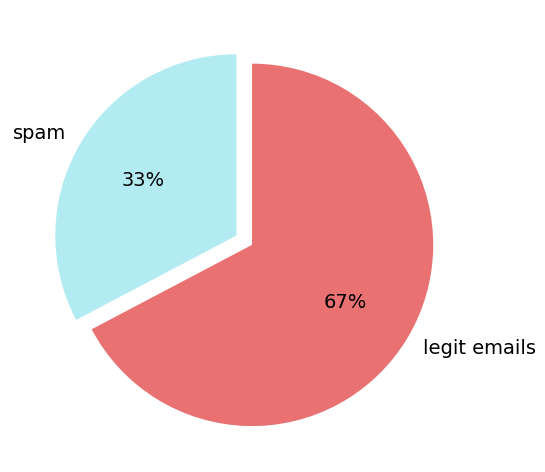

In [21]:
plt.figure(figsize=(6,6),dpi = 100) # dpi: density of pixels per inch
plt.pie(sizes ,labels=category_names,textprops={'fontsize' : 14} ,startangle=90,colors=chart_colors,explode=[0,0.1],
        autopct='%1.0f%%')
plt.show()

# pre processing with Natural laguage processing

### Text pre-processing

## Download NLTK resources (tokenizer and stopwords)

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Nagaraj
[nltk_data]     U\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Tokenizing and Removing stopwords

In [25]:
# Removing stopwords

stop_words = set(stopwords.words('english'))
stopwords

<WordListCorpusReader in 'C:\\Users\\Nagaraj U\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>

## Function to remove HTML tags and punctuation marks in emails. (cleaning)

In [29]:
# Defining function to perform all theese cleaning steps and also removing HtML tags

def clean_messages_no_html(message , stemmer = PorterStemmer() 
                   ,stop_words = set(stopwords.words('english'))):
    filtered_words = []
    
    soup = BeautifulSoup(message , 'html.parser')
    cleaned_text = soup.get_text()
    
    words = word_tokenize(cleaned_text.lower())
    for word in words:
        if word not in stop_words and word.isalpha(): #checking word in stopwords ? and removing punctuation
            filtered_words.append(stemmer.stem(word)) #stemming word
     
    
    
    return filtered_words

In [31]:
#clean_messages_no_html(data.at[0,'MESSAGE'])

## Apply cleaning and tokenization to all emails

### slicing dataframes and series and creating sublists

In [32]:
data[data['CATEGORY'] == 1].shape

(1896, 3)

In [33]:
data[data['CATEGORY'] == 0].shape

(3900, 3)

In [34]:
#Storing index of spam and ham messages in variables

doc_ids_ham = data[data['CATEGORY'] == 0].index  
doc_ids_spam = data[data['CATEGORY'] == 1].index

In [36]:
%%time
nested_list = data['MESSAGE'].apply(clean_messages_no_html)  #List of lists

C:\Users\Nagaraj U\Downloads\anaconda\lib\site-packages\bs4\__init__.py:421: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


Wall time: 36.6 s


In [37]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [38]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_ham = nested_list.loc[doc_ids_ham]

print(type(nested_list_ham))

<class 'pandas.core.series.Series'>


In [39]:
flat_list_spam = []
flat_list_ham = []

for sublist in nested_list_spam:
    for word in sublist:
        flat_list_spam.append(word)

        
         
for sublist in nested_list_ham:
    for word in sublist:
        flat_list_ham.append(word)

In [40]:
print(type(flat_list_ham))

# Converting list to pandas series
normal_words = pd.Series(flat_list_ham).value_counts()
# print(f'total number of normal words : {normal_words.shape[0]}')
print(f'total number of unique normal words : {normal_words.shape[0]}')


spammy_words = pd.Series(flat_list_spam).value_counts()  # value_counts() holds only unique words
# print(f'total number of spammy words : {spammy_words.shape[0]}')
print(f'total number of unique spammy words : {spammy_words.shape[0]}')

<class 'list'>
total number of unique normal words : 20753
total number of unique spammy words : 13172


In [41]:
# Top most used words
print(f'Most used normal words: \n\n{normal_words[:10]}\n')
print(f'\nMost used spammy words: \n\n{spammy_words[:10]}\n')

Most used normal words: 

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64


Most used spammy words: 

email     3090
http      3087
free      2555
click     2055
receiv    1987
list      1971
get       1903
pleas     1837
busi      1792
order     1743
dtype: int64



## Creating wordcloud ( Highlights most occured words)

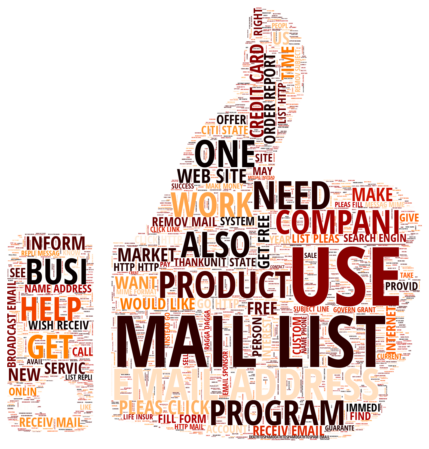

In [42]:
# Generating text as string for spam messages
spam_str = ' '.join(flat_list_spam)

icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array,max_words=2000,background_color='white',max_font_size=300,
                       colormap='gist_heat',font_path=CUSTOM_FONT_FILE)
word_cloud.generate(spam_str.upper())


plt.figure(figsize=(16,8))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

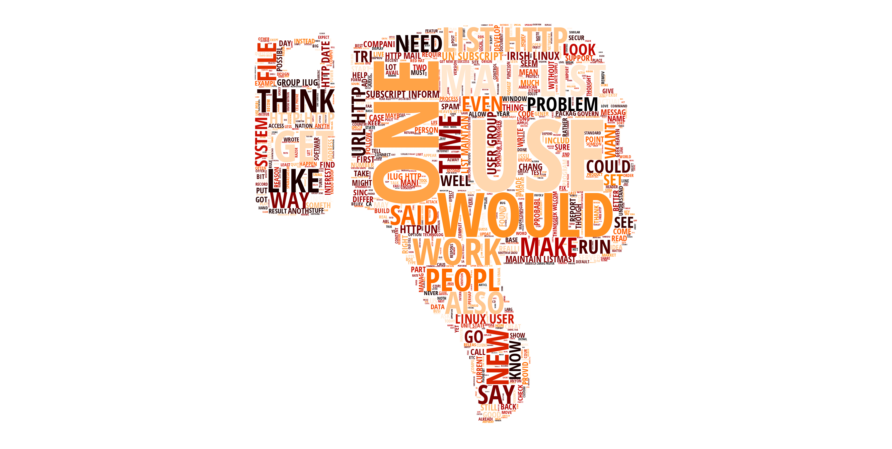

In [43]:
# Generating text as string for ham messages
ham_str = ' '.join(flat_list_ham)

icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array,max_words=2000,background_color='white',max_font_size=300,
                       colormap='gist_heat',font_path=CUSTOM_FONT_FILE)
word_cloud.generate(ham_str.upper())


plt.figure(figsize=(16,8))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate vocabulary and dictionary of words

In [44]:
stemmed_nested_list = data['MESSAGE'].apply(clean_messages_no_html)  # nested list of words in each emails bodies
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [45]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print(f' Total number of unique words : {unique_words.shape[0]}')
unique_words.head()

 Total number of unique words : 27218


http     10648
use       5015
list      4849
email     4366
get       4187
dtype: int64

In [46]:
frequent_words = unique_words[0:VOCABULARY_SIZE]
print( f'Most 10 frequently used words : \n {frequent_words[0:10]}')

Most 10 frequently used words : 
 http     10648
use       5015
list      4849
email     4366
get       4187
mail      3983
one       3905
free      3171
time      3041
work      2880
dtype: int64


## Creating vocacbulary DataFrame with WORD_ID

In [47]:
word_ids = list(range(0,VOCABULARY_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD':frequent_words.index.values})
print(type(vocab))
vocab.index.name= 'WORD_ID'
vocab.head()

<class 'pandas.core.frame.DataFrame'>


,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the vocabulary to csv file

In [48]:
vocab.to_csv(WORD_ID_FILE,index_label=vocab.index.name,header=vocab['VOCAB_WORD'].name)

## Generate features and Sparse matrix


### Creating DataFrame with one wird per column

In [49]:
stemmed_nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [50]:
word_column_df = pd.DataFrame.from_records(stemmed_nested_list.to_list())
word_column_df.head()# converting pandas series to list of list

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [51]:
word_column_df.shape

(5796, 7671)

In [52]:
X_train,X_test,y_train,y_test = train_test_split(word_column_df, data['CATEGORY'], test_size = 0.3, random_state = 42)

In [53]:
X_train.index.name = X_test.index.name = 'DOC_ID' 

In [54]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [55]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Making sparse matrix

In [58]:
word_index = pd.Index(vocab['VOCAB_WORD'])
print(type(word_index))
print(len(word_index))
word_index

<class 'pandas.core.indexes.base.Index'>
2500


Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'murjel', 'bsd', 'occasion', 'congratul', 'fake', 'combat', 'palm',
       'kindli', 'bullet', 'disagre'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [59]:
def make_sparse_matrix(df, indexed_words, labels):
    '''
    returns sparse matrix as dataframe
    
    df : A dataframe with words in the column and document_id as index (X_train , X_test)
    indexed_words : index of words order by word_id
    labels : category as pd series (y_train,y_test)
    '''
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    dict_list = [] # list of dictionaries
    word_set = set(indexed_words)
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL' : category , 'DOC_ID' : doc_id,'WORD_ID' : word_id,'OCCURENCE' : 1}
                
                dict_list.append(item)
    return pd.DataFrame(dict_list)

In [60]:
%%time
sparse_train_df= make_sparse_matrix(X_train,word_index,y_train)

Wall time: 2min 44s


In [61]:
sparse_train_df.head()

,LABEL,DOC_ID,WORD_ID,OCCURENCE
0,0,4844,265,1
1,0,4844,1253,1
2,0,4844,501,1
3,0,4844,308,1
4,0,4844,256,1


In [62]:
sparse_train_df['OCCURENCE'].isnull().any()

False

In [63]:
sparse_train_df.shape

(428364, 4)

## Combine ocuurences with pandas groupby() method

In [64]:
training_grouped_data = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
training_grouped_data.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [65]:
training_grouped_data = training_grouped_data.reset_index()
training_grouped_data.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [66]:
training_grouped_data.shape

(257929, 4)

## Saving training data as .txt file

In [67]:
#saving training data file

np.savetxt(TRAINING_DATA,training_grouped_data,fmt='%d')


In [68]:
%%time
sparse_test_df= make_sparse_matrix(X_test,word_index,y_test)

Wall time: 1min 9s


In [69]:
sparse_test_df.head()

,LABEL,DOC_ID,WORD_ID,OCCURENCE
0,0,4675,88,1
1,0,4675,298,1
2,0,4675,548,1
3,0,4675,84,1
4,0,4675,470,1


In [70]:
testing_grouped_data = sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum().reset_index()

In [71]:
# saving testing data file

np.savetxt(TESTING_DATA,testing_grouped_data,fmt='%d')

In [72]:
testing_grouped_data.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [73]:
sparse_test_df.shape

(202967, 4)